In [1]:

import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from properscoring import crps_gaussian, crps_ensemble
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
#import utils
#import utils_no_early_stopping 
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping

In [2]:
SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

task_id=361072
task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

# Set the random seed for reproducibility
N_TRIALS=100
N_SAMPLES=100
PATIENCE=40
N_EPOCHS=300
GP_ITERATIONS=1000
seed=10
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X.values]

mahalanobis_dist=pd.Series(mahalanobis_dist,index=X.index)
far_index=mahalanobis_dist.index[np.where(mahalanobis_dist>=np.quantile(mahalanobis_dist,0.8))[0]]
close_index=mahalanobis_dist.index[np.where(mahalanobis_dist<np.quantile(mahalanobis_dist,0.8))[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

mean = np.mean(X_train, axis=0)
cov = np.cov(X_train.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist_ = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X_train.values]

mahalanobis_dist_=pd.Series(mahalanobis_dist_,index=X_train.index)
far_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_>=np.quantile(mahalanobis_dist_,0.8))[0]]
close_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_<np.quantile(mahalanobis_dist_,0.8))[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]


# Convert data to PyTorch tensors
X_train__tensor = torch.tensor(X_train_.values, dtype=torch.float32)
y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Convert to use GPU if available
if torch.cuda.is_available():
    X_train__tensor = X_train__tensor.cuda()
    y_train__tensor = y_train__tensor.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

# Create flattened versions of the data
y_val_np = y_val.values.flatten()
y_test_np = y_test.values.flatten()

c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [12]:
N_TRIALS=2

In [13]:
#### MLP
d_out = 1  
d_in=X_train_.shape[1]

def MLP_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout = trial.suggest_float("dropout", 0, 1)

    MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    dropout=dropout,
    )
    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    loss_Adam=[]

    if torch.cuda.is_available():
        MLP_model = MLP_model.cuda()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False)
    n_epochs=train(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train__tensor, y_train__tensor, X_val_tensor, y_val_tensor, early_stopping)
    
    #n_epochs = early_stopping.n_epochs
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    y_val_hat_MLP = (MLP_model(X_val_tensor).reshape(-1,))
    RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

    return RMSE_MLP

sampler_MLP = optuna.samplers.TPESampler(seed=seed)
study_MLP = optuna.create_study(sampler=sampler_MLP, direction='minimize')
study_MLP.optimize(MLP_opt, n_trials=N_TRIALS)

MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_MLP.best_params['n_blocks'],
    d_block=study_MLP.best_params['d_block'],
    dropout=study_MLP.best_params['dropout'],
    )

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()
    
n_epochs=study_MLP.best_params['n_epochs']
learning_rate=study_MLP.best_params['learning_rate']
weight_decay=study_MLP.best_params['weight_decay']
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()
loss_Adam=[]

train_no_early_stopping(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train_tensor, y_train_tensor)

# Point prediction
y_test_hat_MLP = (MLP_model(X_test_tensor).reshape(-1,))
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_MLP)))
print("RMSE MLP: ", RMSE_MLP)

[I 2024-02-06 18:33:42,029] A new study created in memory with name: no-name-458c4038-7304-46bd-b33f-59a8e782b101


Train:   0%|          | 0/300 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counte

[I 2024-02-06 18:33:44,563] Trial 0 finished with value: 278.87677001953125 and parameters: {'n_blocks': 4, 'd_block': 20, 'dropout': 0.6336482349262754, 'learning_rate': 0.010495405390719734, 'weight_decay': 3.1083868392602017e-06, 'n_epochs': 203}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 24 out of 40
EarlyStopping counter: 25 out of 40
EarlyStopping counter: 26 out of 40
EarlyStopping counter: 27 out of 40
EarlyStopping counter: 28 out of 40
EarlyStopping counter: 29 out of 40
EarlyStopping counter: 30 out of 40
EarlyStopping counter: 31 out of 40
EarlyStopping counter: 32 out of 40
EarlyStopping counter: 33 out of 40
EarlyStopping counter: 34 out of 40
EarlyStopping counter: 35 out of 40
EarlyStopping counter: 36 out of 40
EarlyStopping counter: 37 out of 40
EarlyStopping counter: 38 out of 40
EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/300 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counte

[I 2024-02-06 18:33:50,465] Trial 1 finished with value: 10187.9775390625 and parameters: {'n_blocks': 2, 'd_block': 107, 'dropout': 0.7605307121989587, 'learning_rate': 0.0002860388842288948, 'weight_decay': 2.765025054332623e-08, 'n_epochs': 300}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40


Train:   0%|          | 0/203 [00:00<?, ?it/s]

RMSE MLP:  tensor(101.5319, grad_fn=<SqrtBackward0>)


In [7]:
n_epochs

203

In [1]:
import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from properscoring import crps_gaussian, crps_ensemble
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP


SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

task_id=361072
task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

# Set the random seed for reproducibility
N_TRIALS=5
N_SAMPLES=100
PATIENCE=40
N_EPOCHS=1000
GP_ITERATIONS=1000
seed=10
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X.values]

mahalanobis_dist=pd.Series(mahalanobis_dist,index=X.index)
far_index=mahalanobis_dist.index[np.where(mahalanobis_dist>=np.quantile(mahalanobis_dist,0.8))[0]]
close_index=mahalanobis_dist.index[np.where(mahalanobis_dist<np.quantile(mahalanobis_dist,0.8))[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

mean = np.mean(X_train, axis=0)
cov = np.cov(X_train.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist_ = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X_train.values]

mahalanobis_dist_=pd.Series(mahalanobis_dist_,index=X_train.index)
far_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_>=np.quantile(mahalanobis_dist_,0.8))[0]]
close_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_<np.quantile(mahalanobis_dist_,0.8))[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]


# Convert data to PyTorch tensors
X_train__tensor = torch.tensor(X_train_.values, dtype=torch.float32)
y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Convert to use GPU if available
if torch.cuda.is_available():
    X_train__tensor = X_train__tensor.cuda()
    y_train__tensor = y_train__tensor.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
print(X_train__tensor.device)

# Create flattened versions of the data
y_val_np = y_val.values.flatten()
y_test_np = y_test.values.flatten()

c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


cpu


In [2]:
#### MLP
d_out = 1  
d_in=X_train_.shape[1]

def MLP_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout = trial.suggest_float("dropout", 0, 1)

    MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    dropout=dropout,
    )
    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    loss_Adam=[]

    if torch.cuda.is_available():
        MLP_model = MLP_model.cuda()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False)
    n_epochs=train(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train__tensor, y_train__tensor, X_val_tensor, y_val_tensor, early_stopping)
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    y_val_hat_MLP = (MLP_model(X_val_tensor).reshape(-1,))
    RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

    return RMSE_MLP

sampler_MLP = optuna.samplers.TPESampler(seed=seed)
study_MLP = optuna.create_study(sampler=sampler_MLP, direction='minimize')
study_MLP.optimize(MLP_opt, n_trials=N_TRIALS)

MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_MLP.best_params['n_blocks'],
    d_block=study_MLP.best_params['d_block'],
    dropout=study_MLP.best_params['dropout'],
    )

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()
    
n_epochs=study_MLP.best_params['n_epochs']
learning_rate=study_MLP.best_params['learning_rate']
weight_decay=study_MLP.best_params['weight_decay']
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()
loss_Adam=[]

train_no_early_stopping(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train_tensor, y_train_tensor)

# Point prediction
y_test_hat_MLP = (MLP_model(X_test_tensor).reshape(-1,))
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_MLP)))
print("RMSE MLP: ", RMSE_MLP)


[I 2024-02-19 19:21:56,922] A new study created in memory with name: no-name-98442c6d-1dd1-4db1-af39-1243d1cff0be


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counte

[I 2024-02-19 19:22:00,294] Trial 0 finished with value: 278.87677001953125 and parameters: {'n_blocks': 4, 'd_block': 20, 'dropout': 0.6336482349262754, 'learning_rate': 0.010495405390719734, 'weight_decay': 3.1083868392602017e-06, 'n_epochs': 203}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 38 out of 40
EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counte

[I 2024-02-19 19:22:09,992] Trial 1 finished with value: 4307.978515625 and parameters: {'n_blocks': 2, 'd_block': 107, 'dropout': 0.7605307121989587, 'learning_rate': 0.0002860388842288948, 'weight_decay': 2.765025054332623e-08, 'n_epochs': 576}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
EarlyStopping counter: 14 out of 40
EarlyStopping counter: 15 out of 40
EarlyStopping counter: 16 out of 40
EarlyStopping counter: 17 out of 40
EarlyStopping counter: 18 out of 40
EarlyStopping counter: 19 out of 40
EarlyStopping counter: 20 out of 40
EarlyStopping counter: 21 out of 40
EarlyStopping counter: 22 out of 40
EarlyStopping counter: 23 out of 40
EarlyStopping counter: 24 out of 40
EarlyStopping counter: 25 out of 40
EarlyStopping counter: 26 out of 40
EarlyStopping counter: 27 out of 40
Ea

[I 2024-02-19 19:22:20,617] Trial 2 finished with value: 605.7820434570312 and parameters: {'n_blocks': 4, 'd_block': 478, 'dropout': 0.003948266327914451, 'learning_rate': 0.002412079153798176, 'weight_decay': 0.00011563912803570738, 'n_epochs': 48}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counte

[I 2024-02-19 19:22:55,959] Trial 3 finished with value: 612.689208984375 and parameters: {'n_blocks': 4, 'd_block': 364, 'dropout': 0.29187606817063316, 'learning_rate': 0.029994721053560828, 'weight_decay': 3.7400629930578146e-05, 'n_epochs': 225}. Best is trial 0 with value: 278.87677001953125.


EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping co

[I 2024-02-19 19:22:58,143] Trial 4 finished with value: 79.98308563232422 and parameters: {'n_blocks': 3, 'd_block': 79, 'dropout': 0.3733407600514692, 'learning_rate': 0.006598821883612051, 'weight_decay': 1.618698156523955e-06, 'n_epochs': 108}. Best is trial 4 with value: 79.98308563232422.


EarlyStopping counter: 37 out of 40
EarlyStopping counter: 38 out of 40
EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/108 [00:00<?, ?it/s]

RMSE MLP:  tensor(101.8235, grad_fn=<SqrtBackward0>)


In [5]:
def train_2(model, criterion, loss_list, optimizer, n_epochs, train_loader, X_val_tensor, y_val_tensor, early_stopping):
    for epoch in range(n_epochs):
        for batch_X, batch_y in train_loader:
            # Move batch to device
            if torch.cuda.is_available():
                batch_X = batch_X.cuda()
                batch_y = batch_y.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X).reshape(-1,)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # validate the model 
        y_val_hat = model(X_val_tensor).reshape(-1,)
        val_loss = criterion(y_val_hat, y_val_tensor)

        # check if early stopping condition is met
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    return n_epochs

# Similar changes should be made to the train_no_early_stopping function

In [6]:
#### MLP
from torch.utils.data import TensorDataset, DataLoader

d_out = 1  
d_in=X_train_.shape[1]

def MLP_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout = trial.suggest_float("dropout", 0, 1)

    MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    dropout=dropout,
    )

    # Define your batch size
    batch_size = 32

    # Create TensorDatasets for training and validation sets
    train_dataset = TensorDataset(X_train__tensor, y_train__tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    loss_Adam=[]

    if torch.cuda.is_available():
        MLP_model = MLP_model.cuda()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False)
    n_epochs=train_2(MLP_model, criterion, loss_Adam, optimizer, n_epochs, train_loader, X_val_tensor, y_val_tensor, early_stopping)
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    y_val_hat_MLP = (MLP_model(X_val_tensor).reshape(-1,))
    RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

    return RMSE_MLP

sampler_MLP = optuna.samplers.TPESampler(seed=seed)
study_MLP = optuna.create_study(sampler=sampler_MLP, direction='minimize')
study_MLP.optimize(MLP_opt, n_trials=N_TRIALS)

MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_MLP.best_params['n_blocks'],
    d_block=study_MLP.best_params['d_block'],
    dropout=study_MLP.best_params['dropout'],
    )

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()
    
n_epochs=study_MLP.best_params['n_epochs']
learning_rate=study_MLP.best_params['learning_rate']
weight_decay=study_MLP.best_params['weight_decay']
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()
loss_Adam=[]

train_no_early_stopping(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train_tensor, y_train_tensor)

# Point prediction
y_test_hat_MLP = (MLP_model(X_test_tensor).reshape(-1,))
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_MLP)))
print("RMSE MLP: ", RMSE_MLP)


[I 2024-02-19 19:31:12,712] A new study created in memory with name: no-name-cb6c6a86-b0a0-402c-8033-73bcc5096db9


EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping cou

[I 2024-02-19 19:32:17,307] Trial 0 finished with value: 25.29632568359375 and parameters: {'n_blocks': 4, 'd_block': 20, 'dropout': 0.6336482349262754, 'learning_rate': 0.010495405390719734, 'weight_decay': 3.1083868392602017e-06, 'n_epochs': 1000}. Best is trial 0 with value: 25.29632568359375.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
Earl

[I 2024-02-19 19:34:20,909] Trial 1 finished with value: 87.48767852783203 and parameters: {'n_blocks': 2, 'd_block': 107, 'dropout': 0.7605307121989587, 'learning_rate': 0.0002860388842288948, 'weight_decay': 2.765025054332623e-08, 'n_epochs': 1000}. Best is trial 0 with value: 25.29632568359375.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
E

[I 2024-02-19 19:39:16,342] Trial 2 finished with value: 487.8714294433594 and parameters: {'n_blocks': 4, 'd_block': 478, 'dropout': 0.003948266327914451, 'learning_rate': 0.002412079153798176, 'weight_decay': 0.00011563912803570738, 'n_epochs': 1000}. Best is trial 0 with value: 25.29632568359375.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
EarlyStopping counter: 14 out of 40
EarlyStopping counter: 15 out of 40
EarlyStopping counter: 16 out of 40
EarlyStopping counter: 17 out of 40
EarlyStopping counter: 18 out of 40
EarlyStopping counter: 19 out of 40
EarlyStopping counter: 20 out of 40
EarlyStopping counter: 21 out of 40
EarlyStopping counter: 22 out of 40
EarlyStopping counter: 23 

[I 2024-02-19 19:44:57,998] Trial 3 finished with value: 24.827110290527344 and parameters: {'n_blocks': 4, 'd_block': 364, 'dropout': 0.29187606817063316, 'learning_rate': 0.029994721053560828, 'weight_decay': 3.7400629930578146e-05, 'n_epochs': 1000}. Best is trial 3 with value: 24.827110290527344.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
Earl

[I 2024-02-19 19:47:26,837] Trial 4 finished with value: 26.08611297607422 and parameters: {'n_blocks': 3, 'd_block': 79, 'dropout': 0.3733407600514692, 'learning_rate': 0.006598821883612051, 'weight_decay': 1.618698156523955e-06, 'n_epochs': 1000}. Best is trial 3 with value: 24.827110290527344.


EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

RMSE MLP:  tensor(72.0846, grad_fn=<SqrtBackward0>)


In [7]:
#### MLP
from torch.utils.data import TensorDataset, DataLoader

d_out = 1  
d_in=X_train_.shape[1]

def MLP_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout = trial.suggest_float("dropout", 0, 1)

    MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    dropout=dropout,
    )

    # Define your batch size
    batch_size = 256

    # Create TensorDatasets for training and validation sets
    train_dataset = TensorDataset(X_train__tensor, y_train__tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
    loss_Adam=[]

    if torch.cuda.is_available():
        MLP_model = MLP_model.cuda()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False)
    n_epochs=train_2(MLP_model, criterion, loss_Adam, optimizer, n_epochs, train_loader, X_val_tensor, y_val_tensor, early_stopping)
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    y_val_hat_MLP = (MLP_model(X_val_tensor).reshape(-1,))
    RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

    return RMSE_MLP

sampler_MLP = optuna.samplers.TPESampler(seed=seed)
study_MLP = optuna.create_study(sampler=sampler_MLP, direction='minimize')
study_MLP.optimize(MLP_opt, n_trials=N_TRIALS)

MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_MLP.best_params['n_blocks'],
    d_block=study_MLP.best_params['d_block'],
    dropout=study_MLP.best_params['dropout'],
    )

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()
    
n_epochs=study_MLP.best_params['n_epochs']
learning_rate=study_MLP.best_params['learning_rate']
weight_decay=study_MLP.best_params['weight_decay']
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()
loss_Adam=[]

train_no_early_stopping(MLP_model, criterion, loss_Adam, optimizer, n_epochs, X_train_tensor, y_train_tensor)

# Point prediction
y_test_hat_MLP = (MLP_model(X_test_tensor).reshape(-1,))
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_MLP)))
print("RMSE MLP: ", RMSE_MLP)


[I 2024-02-19 19:57:34,317] A new study created in memory with name: no-name-47a5fff5-4807-402c-be8d-6e3fa1743a6d


EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counte

[I 2024-02-19 19:58:59,672] Trial 0 finished with value: 25.075040817260742 and parameters: {'n_blocks': 4, 'd_block': 20, 'dropout': 0.6336482349262754, 'learning_rate': 0.010495405390719734, 'weight_decay': 3.1083868392602017e-06, 'n_epochs': 1000}. Best is trial 0 with value: 25.075040817260742.


EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
Ear

[I 2024-02-19 20:00:01,544] Trial 1 finished with value: 284.2603454589844 and parameters: {'n_blocks': 2, 'd_block': 107, 'dropout': 0.7605307121989587, 'learning_rate': 0.0002860388842288948, 'weight_decay': 2.765025054332623e-08, 'n_epochs': 1000}. Best is trial 0 with value: 25.075040817260742.


EarlyStopping counter: 39 out of 40
EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
EarlyStopping counter: 14 out of 40
EarlyStopping counter: 15 out of 40
EarlyStopping counter: 16 out of 40
EarlyStopping counter: 17 out of 40
EarlyStopping counter: 18 out 

[I 2024-02-19 20:00:44,124] Trial 2 finished with value: 25.508087158203125 and parameters: {'n_blocks': 4, 'd_block': 478, 'dropout': 0.003948266327914451, 'learning_rate': 0.002412079153798176, 'weight_decay': 0.00011563912803570738, 'n_epochs': 1000}. Best is trial 0 with value: 25.075040817260742.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
Earl

[I 2024-02-19 20:01:15,271] Trial 3 finished with value: 263.349853515625 and parameters: {'n_blocks': 4, 'd_block': 364, 'dropout': 0.29187606817063316, 'learning_rate': 0.029994721053560828, 'weight_decay': 3.7400629930578146e-05, 'n_epochs': 1000}. Best is trial 0 with value: 25.075040817260742.


EarlyStopping counter: 40 out of 40
Early stopping
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
EarlyStopping counter: 14 out of 40
EarlyStopping counter: 15 out of 40
EarlyStopping counter: 16 out of 40
EarlyStopping counter: 17 out of 40
EarlyStopping counter: 18 out of 40
EarlyStopping counter: 19 out of 40
EarlyStopping counter: 20 out of 40
EarlyStopping counter: 21 out of 40
EarlyStopping counter: 22 out of 40
EarlyStopping counter: 23 out of 40
EarlyStopping counter: 24

[I 2024-02-19 20:02:39,800] Trial 4 finished with value: 27.705896377563477 and parameters: {'n_blocks': 3, 'd_block': 79, 'dropout': 0.3733407600514692, 'learning_rate': 0.006598821883612051, 'weight_decay': 1.618698156523955e-06, 'n_epochs': 1000}. Best is trial 0 with value: 25.075040817260742.


EarlyStopping counter: 40 out of 40
Early stopping


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

RMSE MLP:  tensor(82.2031, grad_fn=<SqrtBackward0>)


In [8]:
pip show rpy2

Name: rpy2Note: you may need to restart the kernel to use updated packages.

Version: 3.5.15
Summary: Python interface to the R language (embedded R)
Home-page: 
Author: 
Author-email: Laurent Gautier <lgautier@gmail.com>
License: GPLv2+
Location: c:\users\dalma\desktop\thesis_eth_new\code\.venv\lib\site-packages
Requires: cffi, jinja2, packaging, tzlocal
Required-by: drf


In [1]:
from umap import UMAP
import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from properscoring import crps_gaussian, crps_ensemble
import random
import gpytorch
import tqdm.auto as tqdm
from sklearn.metrics.pairwise import euclidean_distances
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader

SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite
benchmark_suite.tasks

[361072,
 361073,
 361074,
 361076,
 361077,
 361078,
 361079,
 361080,
 361081,
 361082,
 361083,
 361084,
 361085,
 361086,
 361087,
 361088,
 361279,
 361280,
 361281]

In [2]:
benchmark_suite.tasks[5:]

[361078,
 361079,
 361080,
 361081,
 361082,
 361083,
 361084,
 361085,
 361086,
 361087,
 361088,
 361279,
 361280,
 361281]

In [2]:
import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from properscoring import crps_gaussian, crps_ensemble
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader


SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

In [3]:
task_id=361074

# Create the checkpoint directory if it doesn't exist
os.makedirs('CHECKPOINTS/MAHALANOBIS', exist_ok=True)
CHECKPOINT_PATH = f'CHECKPOINTS/MAHALANOBIS/task_{task_id}.pt'

print(f"Task {task_id}")

task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

# Set the random seed for reproducibility
N_TRIALS=100
N_SAMPLES=100
PATIENCE=40
N_EPOCHS=1000
GP_ITERATIONS=1000
BATCH_SIZE=1024
seed=10
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X.values]

mahalanobis_dist=pd.Series(mahalanobis_dist,index=X.index)
far_index=mahalanobis_dist.index[np.where(mahalanobis_dist>=np.quantile(mahalanobis_dist,0.8))[0]]
close_index=mahalanobis_dist.index[np.where(mahalanobis_dist<np.quantile(mahalanobis_dist,0.8))[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

mean = np.mean(X_train, axis=0)
cov = np.cov(X_train.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist_ = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in X_train.values]

mahalanobis_dist_=pd.Series(mahalanobis_dist_,index=X_train.index)
far_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_>=np.quantile(mahalanobis_dist_,0.8))[0]]
close_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_<np.quantile(mahalanobis_dist_,0.8))[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]


# Convert data to PyTorch tensors
X_train__tensor = torch.tensor(X_train_.values, dtype=torch.float32)
y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Convert to use GPU if available
if torch.cuda.is_available():
    print("Using GPU")
    X_train__tensor = X_train__tensor.cuda()
    y_train__tensor = y_train__tensor.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
else:
    print("Using CPU")

# Create flattened versions of the data
y_val_np = y_val.values.flatten()
y_test_np = y_test.values.flatten()

# Create TensorDatasets for training and validation sets
train__dataset = TensorDataset(X_train__tensor, y_train__tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and validation sets
train__loader = DataLoader(train__dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Task 361074


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


LinAlgError: Singular matrix

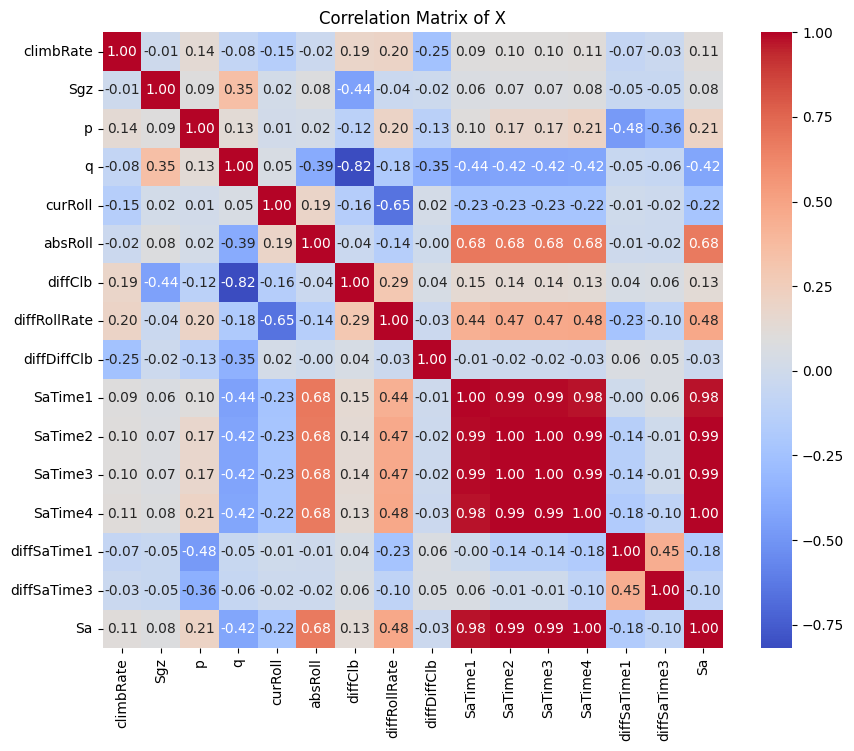

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of X")
plt.show()



In [6]:
# Find features with absolute correlation > 0.9
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop one of the highly correlated features
X = X.drop(high_corr_features, axis=1)

In [7]:
X

,climbRate,Sgz,p,q,curRoll,absRoll,diffClb,diffRollRate,diffDiffClb,SaTime1,diffSaTime1,diffSaTime3
0,118.0,-55.0,-0.28,-0.08,-0.2,-11.0,11.0,0.005,-0.2,-0.0010,0.0000,0.0
1,390.0,-45.0,-0.06,-0.07,-0.6,-12.0,11.0,0.010,-0.2,-0.0008,0.0000,0.0
2,68.0,6.0,0.11,0.15,0.6,-10.0,-9.0,-0.003,-0.2,-0.0011,-0.0002,0.0
3,-358.0,-12.0,-0.20,0.13,-0.3,-11.0,-7.0,0.001,-0.1,-0.0010,0.0000,0.0
4,-411.0,-19.0,-0.18,0.02,-0.5,-11.0,-3.0,0.002,1.2,-0.0010,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16594,299.0,-28.0,0.08,-0.12,-0.3,-9.0,15.0,0.010,-0.2,-0.0005,0.0000,0.0
16595,84.0,0.0,0.14,0.14,1.1,-8.0,-11.0,-0.014,-0.6,-0.0009,0.0000,0.0
16596,-208.0,-6.0,-0.48,0.09,0.2,-9.0,-7.0,-0.010,-0.1,-0.0009,0.0000,0.0
16597,-146.0,-14.0,-0.38,-0.03,-0.8,-10.0,10.0,0.010,-1.0,-0.0005,0.0000,0.0


In [1]:
pip show openml

Name: openml
Version: 0.14.1
Summary: Python API for OpenML
Home-page: https://openml.org/
Author: Matthias Feurer, Jan van Rijn, Arlind Kadra, Pieter Gijsbers, Neeratyoy Mallik, Sahithya Ravi, Andreas Müller, Joaquin Vanschoren and Frank Hutter
Author-email: feurerm@informatik.uni-freiburg.de
License: BSD 3-clause
Location: c:\users\dalma\desktop\thesis_eth_new\code\.venv\lib\site-packages
Requires: liac-arff, minio, numpy, pandas, pyarrow, python-dateutil, requests, scikit-learn, scipy, xmltodict
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [10]:
N_TRIALS=2
def engressor_NN(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01, log=True),
            'num_epoches': trial.suggest_int('num_epoches', 100, 1000),
            'num_layer': trial.suggest_int('num_layer', 2, 5),
            'hidden_dim': trial.suggest_int('hidden_dim', 100, 500),
            'resblock': trial.suggest_categorical('resblock', [True, False])}
    params['noise_dim']=params['hidden_dim']

    # Check if CUDA is available and if so, move the tensors and the model to the GPU
    if torch.cuda.is_available():
        engressor_model=engression(X_train__tensor, y_train__tensor.reshape(-1,1), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=BATCH_SIZE, resblock=params['resblock'], device="cuda")
    else: 
        engressor_model=engression(X_train__tensor, y_train__tensor.reshape(-1,1), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=BATCH_SIZE, resblock=params['resblock'])
    
    # Generate a sample from the engression model for each data point
    y_val_hat_engression=engressor_model.predict(X_val_tensor, target="mean")
    RMSE_engression=torch.sqrt(torch.mean(torch.square(y_val_tensor.reshape(-1,1) - y_val_hat_engression)))

    return RMSE_engression

sampler_engression = optuna.samplers.TPESampler(seed=seed)
study_engression = optuna.create_study(sampler=sampler_engression, direction='minimize')
study_engression.optimize(engressor_NN, n_trials=N_TRIALS)


params=study_engression.best_params
params['noise_dim']=params['hidden_dim']
# Check if CUDA is available and if so, move the tensors and the model to the GPU
if torch.cuda.is_available():
    engressor_model=engression(X_train_tensor, y_train_tensor.reshape(-1,1), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=BATCH_SIZE, resblock=params['resblock'], device="cuda")
else: 
    engressor_model=engression(X_train_tensor, y_train_tensor.reshape(-1,1), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=BATCH_SIZE, resblock=params['resblock'])
y_test_hat_engression=engressor_model.predict(X_test_tensor, target="mean")
RMSE_engression=torch.sqrt(torch.mean(torch.square(y_test_tensor.reshape(-1,1) - y_test_hat_engression)))

print("RMSE engression", RMSE_engression)

[I 2024-02-27 22:22:51,032] A new study created in memory with name: no-name-9c1642ca-8d7b-4ea2-9e93-b88890d73d31


Running on CPU.

Residual blocks (skip-connections) are typically recommended for more than 2 layers; turn it on by setting resblock=True.
Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1024.
[Epoch 1 (0%), batch 6] energy-loss: 0.2750,  E(|Y-Yhat|): 0.7905,  E(|Yhat-Yhat'|): 1.0311
[Epoch 100 (84%), batch 6] energy-loss: 0.2249,  E(|Y-Yhat|): 0.4709,  E(|Yhat-Yhat'|): 0.4920

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.1575,  E(|Y-Yhat|): 2.5551,  E(|Yhat-Yhat'|): 2.7952

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 


[I 2024-02-27 22:24:35,829] Trial 0 finished with value: 9.43673324584961 and parameters: {'learning_rate': 0.0034885205571560775, 'num_epoches': 118, 'num_layer': 4, 'hidden_dim': 400, 'resblock': True}. Best is trial 0 with value: 9.43673324584961.


Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1024.
[Epoch 1 (0%), batch 6] energy-loss: 0.6348,  E(|Y-Yhat|): 0.8215,  E(|Yhat-Yhat'|): 0.3733
[Epoch 100 (13%), batch 6] energy-loss: 0.1723,  E(|Y-Yhat|): 0.3907,  E(|Yhat-Yhat'|): 0.4366
[Epoch 200 (25%), batch 6] energy-loss: 0.2508,  E(|Y-Yhat|): 0.4260,  E(|Yhat-Yhat'|): 0.3503
[Epoch 300 (38%), batch 6] energy-loss: 0.2311,  E(|Y-Yhat|): 0.4403,  E(|Yhat-Yhat'|): 0.4185
[Epoch 400 (51%), batch 6] energy-loss: 0.1729,  E(|Y-Yhat|): 0.3637,  E(|Yhat-Yhat'|): 0.3817
[Epoch 500 (64%), batch 6] energy-loss: 0.2336,  E(|Y-Yhat|): 0.4323,  E(|Yhat-Yhat'|): 0.3974
[Epoch 600 (76%), batch 6] energy-loss: 0.1737,  E(|Y-Yhat|): 0.3741,  E(|Yhat-Yhat'|): 0.4008
[Epoch 700 (89%), batch 6] energy-loss: 0.

[I 2024-02-27 22:26:32,803] Trial 1 finished with value: 22.02121353149414 and parameters: {'learning_rate': 0.0002489577954043506, 'num_epoches': 785, 'num_layer': 2, 'hidden_dim': 135, 'resblock': False}. Best is trial 0 with value: 9.43673324584961.


Running on CPU.

Residual blocks (skip-connections) are typically recommended for more than 2 layers; turn it on by setting resblock=True.
Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1024.
[Epoch 1 (0%), batch 7] energy-loss: 0.3846,  E(|Y-Yhat|): 1.0179,  E(|Yhat-Yhat'|): 1.2667
[Epoch 100 (84%), batch 7] energy-loss: 0.1076,  E(|Y-Yhat|): 0.2529,  E(|Yhat-Yhat'|): 0.2906

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.5237,  E(|Y-Yhat|): 3.4340,  E(|Yhat-Yhat'|): 3.8205

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
RMSE engression tensor(10.0587)


In [8]:
2**10

1024

In [1]:

import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader

SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

task_id=361084

print(f"Task {task_id}")

# Create the checkpoint directory if it doesn't exist
os.makedirs('CHECKPOINTS/CLUSTERING', exist_ok=True)
CHECKPOINT_PATH = f'CHECKPOINTS/CLUSTERING/task_{task_id}.pt'

task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

# Find features with absolute correlation > 0.9
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop one of the highly correlated features
X = X.drop(high_corr_features, axis=1)

Task 361084


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [2]:
corr_matrix

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_month,date_day
bedrooms,1.000000,0.515884,0.576671,0.031703,0.356967,0.477600,0.303093,0.154178,0.018841,0.008931,0.129473,0.391638,0.029244,0.001533,0.008031
bathrooms,0.515884,1.000000,0.754665,0.087740,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042,0.568634,0.087175,0.007392,0.005304
sqft_living,0.576671,0.754665,1.000000,0.172826,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223,0.756420,0.183286,0.011810,0.007246
sqft_lot,0.031703,0.087740,0.172826,1.000000,0.113621,0.183512,0.015286,0.053080,0.007644,0.085683,0.229521,0.144608,0.718557,0.002369,0.000634
grade,0.356967,0.664983,0.762704,0.113621,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372,0.713202,0.119248,0.008376,0.012483
sqft_above,0.477600,0.685342,0.876597,0.183512,0.755923,1.000000,0.051943,0.423898,0.023285,0.000816,0.343803,0.731870,0.194050,0.009872,0.002475
sqft_basement,0.303093,0.283770,0.435043,0.015286,0.168392,0.051943,1.000000,0.133124,0.071323,0.110538,0.144765,0.200355,0.017276,0.006035,0.010405
yr_built,0.154178,0.506019,0.318049,0.053080,0.446963,0.423898,0.133124,1.000000,0.224874,0.148122,0.409356,0.326229,0.070958,0.006226,0.005766
yr_renovated,0.018841,0.050739,0.055363,0.007644,0.014414,0.023285,0.071323,0.224874,1.000000,0.029398,0.068372,0.002673,0.007854,0.012827,0.008127
lat,0.008931,0.024573,0.052529,0.085683,0.114084,0.000816,0.110538,0.148122,0.029398,1.000000,0.135512,0.048858,0.086419,0.014961,0.015655


In [3]:
X.corr().abs()

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_month,date_day
bedrooms,1.000000,0.515884,0.576671,0.031703,0.356967,0.477600,0.303093,0.154178,0.018841,0.008931,0.129473,0.391638,0.029244,0.001533,0.008031
bathrooms,0.515884,1.000000,0.754665,0.087740,0.664983,0.685342,0.283770,0.506019,0.050739,0.024573,0.223042,0.568634,0.087175,0.007392,0.005304
sqft_living,0.576671,0.754665,1.000000,0.172826,0.762704,0.876597,0.435043,0.318049,0.055363,0.052529,0.240223,0.756420,0.183286,0.011810,0.007246
sqft_lot,0.031703,0.087740,0.172826,1.000000,0.113621,0.183512,0.015286,0.053080,0.007644,0.085683,0.229521,0.144608,0.718557,0.002369,0.000634
grade,0.356967,0.664983,0.762704,0.113621,1.000000,0.755923,0.168392,0.446963,0.014414,0.114084,0.198372,0.713202,0.119248,0.008376,0.012483
sqft_above,0.477600,0.685342,0.876597,0.183512,0.755923,1.000000,0.051943,0.423898,0.023285,0.000816,0.343803,0.731870,0.194050,0.009872,0.002475
sqft_basement,0.303093,0.283770,0.435043,0.015286,0.168392,0.051943,1.000000,0.133124,0.071323,0.110538,0.144765,0.200355,0.017276,0.006035,0.010405
yr_built,0.154178,0.506019,0.318049,0.053080,0.446963,0.423898,0.133124,1.000000,0.224874,0.148122,0.409356,0.326229,0.070958,0.006226,0.005766
yr_renovated,0.018841,0.050739,0.055363,0.007644,0.014414,0.023285,0.071323,0.224874,1.000000,0.029398,0.068372,0.002673,0.007854,0.012827,0.008127
lat,0.008931,0.024573,0.052529,0.085683,0.114084,0.000816,0.110538,0.148122,0.029398,1.000000,0.135512,0.048858,0.086419,0.014961,0.015655


In [4]:
# Set the random seed for reproducibility
N_TRIALS=100
N_SAMPLES=100
PATIENCE=40
N_EPOCHS=1000
GP_ITERATIONS=1000
BATCH_SIZE=1024
seed=10
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


# New new implementation
N_CLUSTERS=20
# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)
scaler = StandardScaler()

# transform data to compute the clusters
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X_scaled)
distances=[]
mahalanobis_dist=[]
counts=[]
ideal_len=len(kmeans.labels_)/5
for i in np.arange(N_CLUSTERS):
    distances.append(np.abs(np.sum(kmeans.labels_==i)-ideal_len))
    counts.append(np.sum(kmeans.labels_==i))
    mean_k= np.mean(X.loc[kmeans.labels_==i,:], axis=0)
    mahalanobis_dist.append(mahalanobis(mean_k, mean, np.linalg.inv(cov)))

dist_df=pd.DataFrame(data={'mahalanobis_dist': mahalanobis_dist, 'count': counts}, index=np.arange(N_CLUSTERS))
dist_df=dist_df.sort_values('mahalanobis_dist', ascending=False)
dist_df['cumulative_count']=dist_df['count'].cumsum()
dist_df['abs_diff']=np.abs(dist_df['cumulative_count']-ideal_len)

final=(np.where(dist_df['abs_diff']==np.min(dist_df['abs_diff']))[0])[0]
labelss=dist_df.index[0:final+1].to_list()
labels=pd.Series(kmeans.labels_).isin(labelss)
labels.index=X.index
close_index=labels.index[np.where(labels==False)[0]]
far_index=labels.index[np.where(labels==True)[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

# calculate the mean and covariance matrix of the dataset
mean_ = np.mean(X_train, axis=0)
cov_ = np.cov(X_train.T)
scaler_ = StandardScaler()

# transform data to compute the clusters
X_train_scaled = scaler_.fit_transform(X_train)

kmeans_ = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X_train_scaled)
distances_=[]
counts_=[]
mahalanobis_dist_=[]
ideal_len_=len(kmeans_.labels_)/5
for i in np.arange(N_CLUSTERS):
    distances_.append(np.abs(np.sum(kmeans_.labels_==i)-ideal_len_))
    counts_.append(np.sum(kmeans_.labels_==i))
    mean_k_= np.mean(X_train.loc[kmeans_.labels_==i,:], axis=0)
    mahalanobis_dist_.append(mahalanobis(mean_k_, mean_, np.linalg.inv(cov_)))

dist_df_=pd.DataFrame(data={'mahalanobis_dist': mahalanobis_dist_, 'count': counts_}, index=np.arange(N_CLUSTERS))
dist_df_=dist_df_.sort_values('mahalanobis_dist', ascending=False)
dist_df_['cumulative_count']=dist_df_['count'].cumsum()
dist_df_['abs_diff']=np.abs(dist_df_['cumulative_count']-ideal_len_)

final_=(np.where(dist_df_['abs_diff']==np.min(dist_df_['abs_diff']))[0])[0]
labelss_=dist_df_.index[0:final_+1].to_list()
labels_=pd.Series(kmeans_.labels_).isin(labelss_)
labels_.index=X_train.index
close_index_=labels_.index[np.where(labels_==False)[0]]
far_index_=labels_.index[np.where(labels_==True)[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]


    # Standardize the data
mean_X_train_ = np.mean(X_train_, axis=0)
std_X_train_ = np.std(X_train_, axis=0)
X_train__scaled = (X_train_ - mean_X_train_) / std_X_train_
X_val_scaled = (X_val - mean_X_train_) / std_X_train_

mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean_X_train) / std_X_train
X_test_scaled = (X_test - mean_X_train) / std_X_train


# Convert data to PyTorch tensors
X_train__tensor = torch.tensor(X_train__scaled.values, dtype=torch.float32)
y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Convert to use GPU if available
if torch.cuda.is_available():
    print("Using GPU")
    X_train__tensor = X_train__tensor.cuda()
    y_train__tensor = y_train__tensor.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
else:
    print("Using CPU")

# Create flattened versions of the data
y_val_np = y_val.values.flatten()
y_test_np = y_test.values.flatten()

# Create TensorDatasets for training and validation sets
train__dataset = TensorDataset(X_train__tensor, y_train__tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and validation sets
train__loader = DataLoader(train__dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LinAlgError: Singular matrix

In [10]:
np.sum(np.sum(np.isnan(X_train.corr().abs())))

c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


29

In [7]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_month,date_day
0,3,1.00,1180.0,5650.0,7,1180.0,0.0,1955.0,0.0,47.5112,-122.257,1340.0,5650.0,10,13
2,2,1.00,770.0,10000.0,6,770.0,0.0,1933.0,0.0,47.7379,-122.233,2720.0,8062.0,2,25
3,4,3.00,1960.0,5000.0,7,1050.0,910.0,1965.0,0.0,47.5208,-122.393,1360.0,5000.0,12,9
4,3,2.00,1680.0,8080.0,8,1680.0,0.0,1987.0,0.0,47.6168,-122.045,1800.0,7503.0,2,18
6,3,2.25,1715.0,6819.0,7,1715.0,0.0,1995.0,0.0,47.3097,-122.327,2238.0,6819.0,6,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21603,3,2.50,2270.0,5536.0,8,2270.0,0.0,2003.0,0.0,47.5389,-121.881,2270.0,5731.0,8,25
21605,4,2.50,2520.0,6023.0,9,2520.0,0.0,2014.0,0.0,47.5137,-122.167,2520.0,6023.0,10,14
21606,4,3.50,3510.0,7200.0,9,2600.0,910.0,2009.0,0.0,47.5537,-122.398,2050.0,6200.0,3,26
21609,4,2.50,2310.0,5813.0,8,2310.0,0.0,2014.0,0.0,47.5107,-122.362,1830.0,7200.0,2,23


In [8]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_month,date_day
0,3,1.00,1180.0,5650.0,7,1180.0,0.0,1955.0,0.0,47.5112,-122.257,1340.0,5650.0,10,13
1,3,2.25,2570.0,7242.0,7,2170.0,400.0,1951.0,1991.0,47.7210,-122.319,1690.0,7639.0,12,9
2,2,1.00,770.0,10000.0,6,770.0,0.0,1933.0,0.0,47.7379,-122.233,2720.0,8062.0,2,25
3,4,3.00,1960.0,5000.0,7,1050.0,910.0,1965.0,0.0,47.5208,-122.393,1360.0,5000.0,12,9
4,3,2.00,1680.0,8080.0,8,1680.0,0.0,1987.0,0.0,47.6168,-122.045,1800.0,7503.0,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530.0,1131.0,8,1530.0,0.0,2009.0,0.0,47.6993,-122.346,1530.0,1509.0,5,21
21609,4,2.50,2310.0,5813.0,8,2310.0,0.0,2014.0,0.0,47.5107,-122.362,1830.0,7200.0,2,23
21610,2,0.75,1020.0,1350.0,7,1020.0,0.0,2009.0,0.0,47.5944,-122.299,1020.0,2007.0,6,23
21611,3,2.50,1600.0,2388.0,8,1600.0,0.0,2004.0,0.0,47.5345,-122.069,1410.0,1287.0,1,16


In [1]:
import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from properscoring import crps_gaussian, crps_ensemble
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

#task_id=361072
for task_id in benchmark_suite.tasks[10:]:

    print(f"Task {task_id}")

    # Create the checkpoint directory if it doesn't exist
    os.makedirs('CHECKPOINTS/SPATIAL_DEPTH', exist_ok=True)
    CHECKPOINT_PATH = f'CHECKPOINTS/SPATIAL_DEPTH/task_{task_id}.pt'

    task = openml.tasks.get_task(task_id)  # download the OpenML task
    dataset = task.get_dataset()

    X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format="dataframe", target=dataset.default_target_attribute)
    
    if len(X)>=100000:
        continue
    
    # Find features with absolute correlation > 0.9
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

    # Drop one of the highly correlated features
    X = X.drop(high_corr_features, axis=1)

    # Set the random seed for reproducibility
    N_TRIALS=100
    N_SAMPLES=100
    PATIENCE=40
    N_EPOCHS=1000
    GP_ITERATIONS=1000
    BATCH_SIZE=1024
    seed=10
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)


    # activate pandas conversion for rpy2
    pandas2ri.activate()

    # import R's "ddalpha" package
    ddalpha = importr('ddalpha')

    # explicitly import the projDepth function
    spatialDepth = robjects.r['depth.spatial']

    # calculate the spatial depth for each data point
    spatial_depth = spatialDepth(X, X)

    spatial_depth=pd.Series(spatial_depth,index=X.index)
    far_index=spatial_depth.index[np.where(spatial_depth<=np.quantile(spatial_depth,0.2))[0]]
    close_index=spatial_depth.index[np.where(spatial_depth>np.quantile(spatial_depth,0.2))[0]]

    X_train = X.loc[close_index,:]
    X_test = X.loc[far_index,:]
    y_train = y.loc[close_index]
    y_test = y.loc[far_index]

    # convert the R vector to a pandas Series
    spatial_depth_ = spatialDepth(X_train, X_train)

    spatial_depth_=pd.Series(spatial_depth_,index=X_train.index)
    far_index_=spatial_depth_.index[np.where(spatial_depth_<=np.quantile(spatial_depth_,0.2))[0]]
    close_index_=spatial_depth_.index[np.where(spatial_depth_>np.quantile(spatial_depth_,0.2))[0]]

    X_train_ = X_train.loc[close_index_,:]
    X_val = X_train.loc[far_index_,:]
    y_train_ = y_train.loc[close_index_]
    y_val = y_train.loc[far_index_]


        # Standardize the data
    mean_X_train_ = np.mean(X_train_, axis=0)
    std_X_train_ = np.std(X_train_, axis=0)
    X_train__scaled = (X_train_ - mean_X_train_) / std_X_train_
    X_val_scaled = (X_val - mean_X_train_) / std_X_train_

    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean_X_train) / std_X_train
    X_test_scaled = (X_test - mean_X_train) / std_X_train


    # Convert data to PyTorch tensors
    X_train__tensor = torch.tensor(X_train__scaled.values, dtype=torch.float32)
    y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Convert to use GPU if available
    if torch.cuda.is_available():
        print("Using GPU")
        X_train__tensor = X_train__tensor.cuda()
        y_train__tensor = y_train__tensor.cuda()
        X_train_tensor = X_train_tensor.cuda()
        y_train_tensor = y_train_tensor.cuda()
        X_val_tensor = X_val_tensor.cuda()
        y_val_tensor = y_val_tensor.cuda()
        X_test_tensor = X_test_tensor.cuda()
        y_test_tensor = y_test_tensor.cuda()
    else:
        print("Using CPU")

    # Create flattened versions of the data
    y_val_np = y_val.values.flatten()
    y_test_np = y_test.values.flatten()

    # Create TensorDatasets for training and validation sets
    train__dataset = TensorDataset(X_train__tensor, y_train__tensor)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders for training and validation sets
    train__loader = DataLoader(train__dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Define d_out and d_in
    d_out = 1  
    d_in=X_train_.shape[1]
    break

Task 361083


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


Task 361084


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [1]:
import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader

SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

#task_id=361072
i=12
for task_id in benchmark_suite.tasks[12:]:
    print(i)
    i=i+1
    print(f"Task {task_id}")

    task = openml.tasks.get_task(task_id)  # download the OpenML task
    dataset = task.get_dataset()

    X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format="dataframe", target=dataset.default_target_attribute)
    
    print(len(X))

12
Task 361085


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


10081
13
Task 361086


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


163065
14
Task 361087
13932
15
Task 361088


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will defa

21263
16
Task 361279
8885
17
Task 361280


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will defa

4177
18
Task 361281


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


5465575


In [3]:

import pandas as pd
import numpy as np
import setuptools
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
import random
import gpytorch
import tqdm.auto as tqdm
import os
from pygam import LinearGAM, s, f
from utils import EarlyStopping, train, train_trans, train_no_early_stopping, train_trans_no_early_stopping, train_GP, ExactGPModel
from torch.utils.data import TensorDataset, DataLoader

SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

task_id=361279

print(f"Task {task_id}")

# Create the checkpoint directory if it doesn't exist
os.makedirs('CHECKPOINTS/CLUSTERING', exist_ok=True)
CHECKPOINT_PATH = f'CHECKPOINTS/CLUSTERING/task_{task_id}.pt'

task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

# Find features with absolute correlation > 0.9
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop one of the highly correlated features
X = X.drop(high_corr_features, axis=1)

# Set the random seed for reproducibility
N_TRIALS=100
N_SAMPLES=100
PATIENCE=40
N_EPOCHS=1000
GP_ITERATIONS=1000
BATCH_SIZE=1024
seed=10
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)


# New new implementation
N_CLUSTERS=20
# calculate the mean and covariance matrix of the dataset
mean = np.mean(X, axis=0)
cov = np.cov(X.T)
scaler = StandardScaler()

# transform data to compute the clusters
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X_scaled)
distances=[]
mahalanobis_dist=[]
counts=[]
ideal_len=len(kmeans.labels_)/5
for i in np.arange(N_CLUSTERS):
    distances.append(np.abs(np.sum(kmeans.labels_==i)-ideal_len))
    counts.append(np.sum(kmeans.labels_==i))
    mean_k= np.mean(X.loc[kmeans.labels_==i,:], axis=0)
    mahalanobis_dist.append(mahalanobis(mean_k, mean, np.linalg.inv(cov)))

dist_df=pd.DataFrame(data={'mahalanobis_dist': mahalanobis_dist, 'count': counts}, index=np.arange(N_CLUSTERS))
dist_df=dist_df.sort_values('mahalanobis_dist', ascending=False)
dist_df['cumulative_count']=dist_df['count'].cumsum()
dist_df['abs_diff']=np.abs(dist_df['cumulative_count']-ideal_len)

final=(np.where(dist_df['abs_diff']==np.min(dist_df['abs_diff']))[0])[0]
labelss=dist_df.index[0:final+1].to_list()
labels=pd.Series(kmeans.labels_).isin(labelss)
labels.index=X.index
close_index=labels.index[np.where(labels==False)[0]]
far_index=labels.index[np.where(labels==True)[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]

# calculate the mean and covariance matrix of the dataset
mean_ = np.mean(X_train, axis=0)
cov_ = np.cov(X_train.T)
scaler_ = StandardScaler()

# transform data to compute the clusters
X_train_scaled = scaler_.fit_transform(X_train)

kmeans_ = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X_train_scaled)
distances_=[]
counts_=[]
mahalanobis_dist_=[]
ideal_len_=len(kmeans_.labels_)/5
for i in np.arange(N_CLUSTERS):
    distances_.append(np.abs(np.sum(kmeans_.labels_==i)-ideal_len_))
    counts_.append(np.sum(kmeans_.labels_==i))
    mean_k_= np.mean(X_train.loc[kmeans_.labels_==i,:], axis=0)
    mahalanobis_dist_.append(mahalanobis(mean_k_, mean_, np.linalg.inv(cov_)))

dist_df_=pd.DataFrame(data={'mahalanobis_dist': mahalanobis_dist_, 'count': counts_}, index=np.arange(N_CLUSTERS))
dist_df_=dist_df_.sort_values('mahalanobis_dist', ascending=False)
dist_df_['cumulative_count']=dist_df_['count'].cumsum()
dist_df_['abs_diff']=np.abs(dist_df_['cumulative_count']-ideal_len_)

final_=(np.where(dist_df_['abs_diff']==np.min(dist_df_['abs_diff']))[0])[0]
labelss_=dist_df_.index[0:final_+1].to_list()
labels_=pd.Series(kmeans_.labels_).isin(labelss_)
labels_.index=X_train.index
close_index_=labels_.index[np.where(labels_==False)[0]]
far_index_=labels_.index[np.where(labels_==True)[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]


    # Standardize the data
mean_X_train_ = np.mean(X_train_, axis=0)
std_X_train_ = np.std(X_train_, axis=0)
X_train__scaled = (X_train_ - mean_X_train_) / std_X_train_
X_val_scaled = (X_val - mean_X_train_) / std_X_train_

mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean_X_train) / std_X_train
X_test_scaled = (X_test - mean_X_train) / std_X_train


# Convert data to PyTorch tensors
X_train__tensor = torch.tensor(X_train__scaled.values, dtype=torch.float32)
y_train__tensor = torch.tensor(y_train_.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Convert to use GPU if available
if torch.cuda.is_available():
    print("Using GPU")
    X_train__tensor = X_train__tensor.cuda()
    y_train__tensor = y_train__tensor.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()
else:
    print("Using CPU")

# Create flattened versions of the data
y_val_np = y_val.values.flatten()
y_test_np = y_test.values.flatten()

# Create TensorDatasets for training and validation sets
train__dataset = TensorDataset(X_train__tensor, y_train__tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and validation sets
train__loader = DataLoader(train__dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define d_out and d_in
d_out = 1  
d_in=X_train_.shape[1]

#### MLP
def MLP_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout = trial.suggest_float("dropout", 0, 1)

    MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    dropout=dropout,
    )
    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    if torch.cuda.is_available():
        MLP_model = MLP_model.cuda()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=CHECKPOINT_PATH)
    n_epochs=train(MLP_model, criterion, optimizer, n_epochs, train__loader, val_loader, early_stopping, CHECKPOINT_PATH)
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    predictions = []
    with torch.no_grad():
        for batch_X, _ in val_loader:
            batch_predictions = MLP_model(batch_X).reshape(-1,)
            predictions.append(batch_predictions.cpu().numpy())

    y_val_hat_MLP = torch.Tensor(np.concatenate(predictions))
    if torch.cuda.is_available():
        y_val_hat_MLP = y_val_hat_MLP.cuda()
    RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

    return RMSE_MLP

sampler_MLP = optuna.samplers.TPESampler(seed=seed)
study_MLP = optuna.create_study(sampler=sampler_MLP, direction='minimize')
study_MLP.optimize(MLP_opt, n_trials=N_TRIALS)

MLP_model = MLP(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_MLP.best_params['n_blocks'],
    d_block=study_MLP.best_params['d_block'],
    dropout=study_MLP.best_params['dropout'],
    )

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()
    
n_epochs=study_MLP.best_params['n_epochs']
learning_rate=study_MLP.best_params['learning_rate']
weight_decay=study_MLP.best_params['weight_decay']
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

train_no_early_stopping(MLP_model, criterion, optimizer, n_epochs, train_loader)

# Point prediction
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_predictions = MLP_model(batch_X).reshape(-1,)
        predictions.append(batch_predictions.cpu().numpy())

y_test_hat_MLP = torch.Tensor(np.concatenate(predictions))
if torch.cuda.is_available():
    y_test_hat_MLP = y_test_hat_MLP.cuda()
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_MLP)))
print("RMSE MLP: ", RMSE_MLP)
del MLP_model, optimizer, criterion, y_test_hat_MLP, predictions

Task 361279


c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
[I 2024-03-18 20:14:50,123] A new study created in memory with name: no-name-bef93cda-3f8e-4483-98de-1ea06ce8430f


Using CPU


[W 2024-03-18 20:17:09,038] Trial 0 failed with parameters: {'n_blocks': 4, 'd_block': 20, 'dropout': 0.6336482349262754, 'learning_rate': 0.010495405390719734, 'weight_decay': 3.1083868392602017e-06, 'n_epochs': 1000} because of the following error: The value nan is not acceptable.
[W 2024-03-18 20:17:09,075] Trial 0 failed with value tensor(nan).
[W 2024-03-18 20:17:24,775] Trial 1 failed with parameters: {'n_blocks': 2, 'd_block': 107, 'dropout': 0.7605307121989587, 'learning_rate': 0.0002860388842288948, 'weight_decay': 2.765025054332623e-08} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dalma\AppData\Local\Temp\ipykernel_22820\289053326.py", line 228, in MLP_opt
    n_epochs=train(MLP_model, criterion, optimizer, n_epochs, train__loader, val_loader, early_stopping,

KeyboardInterrupt: 

In [18]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

n_blocks = 1
d_block = 20
dropout = 0.5
MLP_model = MLP(
d_in=d_in,
d_out=d_out,
n_blocks=n_blocks,
d_block=d_block,
dropout=dropout,
)   
n_epochs=N_EPOCHS
learning_rate=0.001
weight_decay=1e-8
optimizer=torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

if torch.cuda.is_available():
    MLP_model = MLP_model.cuda()

early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=CHECKPOINT_PATH)
n_epochs=train(MLP_model, criterion, optimizer, n_epochs, train__loader, val_loader, early_stopping, CHECKPOINT_PATH)
#n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

In [19]:
# Point prediction
predictions = []
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_predictions = MLP_model(batch_X).reshape(-1,)
        predictions.append(batch_predictions.cpu().numpy())

y_val_hat_MLP = torch.Tensor(np.concatenate(predictions))
if torch.cuda.is_available():
    y_val_hat_MLP = y_val_hat_MLP.cuda()
RMSE_MLP=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_MLP)))

In [23]:
MLP_model

MLP(
  (blocks): ModuleList(
    (0): Sequential(
      (linear): Linear(in_features=38, out_features=20, bias=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=20, out_features=1, bias=True)
)

In [26]:
y_train_

0       0.983921
1       0.916621
3       0.912105
4       0.914634
5       0.910027
          ...   
8877    0.944806
8878    0.907136
8881    0.988708
8882    0.903162
8883    0.990515
Name: oz252, Length: 5744, dtype: float64

In [32]:
np.std(X_val['oz87'])

0.034199922696794414

In [30]:
X.corr()

,oz1,oz2,oz5,oz6,oz9,oz10,oz11,oz12,oz13,oz31,...,oz178,oz183,oz185,oz197,oz246,oz247,oz248,oz249,oz250,oz251
oz1,1.000000,-0.273602,-0.140465,0.010467,-0.025167,-0.131809,-0.039172,0.011603,-0.050456,-0.051287,...,-0.084987,-0.080928,-0.037376,-0.075661,-0.029370,-0.037655,0.022205,-0.116815,-0.084989,0.057565
oz2,-0.273602,1.000000,-0.085644,-0.229852,-0.239174,-0.147636,-0.176033,0.479102,0.547327,-0.037036,...,-0.101362,0.056882,-0.014909,0.055853,0.776882,-0.028311,0.698548,0.261746,0.152658,0.134318
oz5,-0.140465,-0.085644,1.000000,0.114997,0.060127,0.276922,0.328889,-0.215681,0.016218,0.276900,...,0.158018,0.160974,0.300852,0.008218,-0.139639,-0.095501,-0.320399,0.319916,0.150831,0.081910
oz6,0.010467,-0.229852,0.114997,1.000000,-0.058666,-0.042387,-0.056353,-0.134975,-0.178674,0.079225,...,0.046867,0.091201,0.109105,0.086495,-0.231269,-0.002247,-0.322788,0.286721,0.031031,0.152620
oz9,-0.025167,-0.239174,0.060127,-0.058666,1.000000,0.432189,0.401716,-0.211196,-0.174930,0.033746,...,0.168098,-0.042534,0.002250,-0.043691,-0.281464,-0.079321,-0.387844,0.183621,-0.077778,0.159365
oz10,-0.131809,-0.147636,0.276922,-0.042387,0.432189,1.000000,0.440420,-0.154072,-0.128020,0.279366,...,0.236421,0.148055,0.202714,-0.023876,-0.186567,0.167520,-0.361038,0.307490,0.140182,0.028103
oz11,-0.039172,-0.176033,0.328889,-0.056353,0.401716,0.440420,1.000000,-0.140198,-0.138477,0.103611,...,0.255415,0.052165,0.065062,-0.060617,-0.192377,0.021815,-0.297188,0.210083,-0.001328,0.154084
oz12,0.011603,0.479102,-0.215681,-0.134975,-0.211196,-0.154072,-0.140198,1.000000,0.571512,-0.090388,...,-0.088996,0.066911,-0.033344,0.067898,0.774787,-0.192934,0.696208,0.562730,0.084040,0.460516
oz13,-0.050456,0.547327,0.016218,-0.178674,-0.174930,-0.128020,-0.138477,0.571512,1.000000,-0.039554,...,-0.083885,0.103985,-0.007211,-0.001105,0.764423,0.050421,0.626047,0.540296,0.245347,0.233699
oz31,-0.051287,-0.037036,0.276900,0.079225,0.033746,0.279366,0.103611,-0.090388,-0.039554,1.000000,...,0.045437,0.395545,0.730116,-0.046474,-0.010470,-0.050936,-0.192889,0.186449,0.354588,-0.017327


In [27]:
X_train_.corr()

,oz1,oz2,oz5,oz6,oz9,oz10,oz11,oz12,oz13,oz31,...,oz178,oz183,oz185,oz197,oz246,oz247,oz248,oz249,oz250,oz251
oz1,1.000000,0.280895,-0.083059,0.007783,-0.060460,-0.014210,-0.084494,0.304376,0.156411,-0.098912,...,-0.020559,-0.147482,-0.086607,-0.054875,0.314936,-0.015068,0.332724,0.201221,-0.073183,0.299677
oz2,0.280895,1.000000,-0.116349,-0.129057,-0.105957,-0.091858,-0.167797,0.378954,0.442770,-0.073512,...,-0.071750,-0.096255,-0.047670,-0.078564,0.677738,-0.000836,0.662103,0.300505,0.021179,0.262485
oz5,-0.083059,-0.116349,1.000000,0.134819,0.023010,0.053768,0.166708,-0.215724,0.034366,0.131824,...,0.054138,0.075510,0.210204,0.019698,-0.166455,-0.160602,-0.350819,0.188942,0.060327,0.063637
oz6,0.007783,-0.129057,0.134819,1.000000,-0.089136,-0.039200,-0.038255,-0.059768,-0.155801,0.145785,...,0.032497,0.184388,0.206157,0.104599,-0.118130,-0.018723,-0.324202,0.183486,0.114383,0.012223
oz9,-0.060460,-0.105957,0.023010,-0.089136,1.000000,0.259486,0.190425,-0.099696,-0.020137,0.081924,...,0.076615,0.043801,0.040417,0.028205,-0.111427,-0.038288,-0.235751,0.038436,0.029411,-0.021528
oz10,-0.014210,-0.091858,0.053768,-0.039200,0.259486,1.000000,0.161689,0.049208,-0.016150,0.130218,...,0.169327,0.147388,0.103499,0.043581,-0.018755,-0.058197,-0.206432,0.157785,0.131084,0.016295
oz11,-0.084494,-0.167797,0.166708,-0.038255,0.190425,0.161689,1.000000,-0.029685,-0.065076,0.063633,...,0.031694,0.042334,0.027637,-0.009680,-0.105179,-0.056420,-0.205251,0.061109,0.013738,0.057362
oz12,0.304376,0.378954,-0.215724,-0.059768,-0.099696,0.049208,-0.029685,1.000000,0.533218,-0.085253,...,-0.014387,0.022913,-0.046656,0.000600,0.800944,-0.266241,0.625882,0.754391,0.014906,0.633380
oz13,0.156411,0.442770,0.034366,-0.155801,-0.020137,-0.016150,-0.065076,0.533218,1.000000,-0.045402,...,-0.005104,0.041842,-0.018300,-0.051850,0.760464,-0.025088,0.539550,0.679838,0.199864,0.405258
oz31,-0.098912,-0.073512,0.131824,0.145785,0.081924,0.130218,0.063633,-0.085253,-0.045402,1.000000,...,0.017798,0.254547,0.599075,-0.109544,-0.057347,-0.090426,-0.194852,0.036309,0.183754,0.004690


In [22]:
batch_predictions

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [20]:
y_val_hat_MLP

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [16]:
val_loader

In [17]:
len(X_val)

1445

In [8]:
np.sum(np.isnan(X_train_))

c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


oz1      0
oz2      0
oz5      0
oz6      0
oz9      0
oz10     0
oz11     0
oz12     0
oz13     0
oz31     0
oz83     0
oz87     0
oz124    0
oz125    0
oz126    0
oz127    0
oz128    0
oz131    0
oz133    0
oz150    0
oz151    0
oz165    0
oz171    0
oz172    0
oz173    0
oz175    0
oz176    0
oz177    0
oz178    0
oz183    0
oz185    0
oz197    0
oz246    0
oz247    0
oz248    0
oz249    0
oz250    0
oz251    0
dtype: int64

In [13]:
len(X_val)/(len(X_train))

0.20100153011545416

In [14]:
# #### ResNet
def ResNet_opt(trial):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    n_blocks = trial.suggest_int("n_blocks", 1, 5)
    d_block = trial.suggest_int("d_block", 10, 500)
    dropout1 = trial.suggest_float("dropout1", 0, 1)
    dropout2 = trial.suggest_float("dropout2", 0, 1)
    d_hidden_multiplier=trial.suggest_float("d_hidden_multiplier", 0.5, 3)

    ResNet_model = ResNet(
    d_in=d_in,
    d_out=d_out,
    n_blocks=n_blocks,
    d_block=d_block,
    d_hidden=None,
    d_hidden_multiplier=d_hidden_multiplier,
    dropout1=dropout1,
    dropout2=dropout2,
    )
    if torch.cuda.is_available():
        ResNet_model = ResNet_model.cuda()
    n_epochs=N_EPOCHS
    learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.05, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-8, 1e-3, log=True)
    optimizer=torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=CHECKPOINT_PATH)
    n_epochs=train(ResNet_model, criterion, optimizer, n_epochs, train__loader, val_loader, early_stopping, CHECKPOINT_PATH)
    n_epochs = trial.suggest_int('n_epochs', n_epochs, n_epochs)

    # Point prediction
    predictions = []
    with torch.no_grad():
        for batch_X, _ in val_loader:
            batch_predictions = ResNet_model(batch_X).reshape(-1,)
            predictions.append(batch_predictions.cpu().numpy())

    y_val_hat_ResNet = torch.Tensor(np.concatenate(predictions))
    if torch.cuda.is_available():
        y_val_hat_ResNet = y_val_hat_ResNet.cuda()
    RMSE_ResNet=torch.sqrt(torch.mean(torch.square(y_val_tensor - y_val_hat_ResNet)))

    return RMSE_ResNet

sampler_ResNet = optuna.samplers.TPESampler(seed=seed)
study_ResNet = optuna.create_study(sampler=sampler_ResNet, direction='minimize')
study_ResNet.optimize(ResNet_opt, n_trials=N_TRIALS)

ResNet_model = ResNet(
    d_in=d_in,
    d_out=d_out,
    n_blocks=study_ResNet.best_params['n_blocks'],
    d_block=study_ResNet.best_params['d_block'],
    d_hidden=None,
    d_hidden_multiplier=study_ResNet.best_params['d_hidden_multiplier'],
    dropout1=study_ResNet.best_params['dropout1'],
    dropout2=study_ResNet.best_params['dropout2'],
    )

if torch.cuda.is_available():
    ResNet_model = ResNet_model.cuda()

n_epochs=study_ResNet.best_params['n_epochs']
learning_rate=study_ResNet.best_params['learning_rate']
weight_decay=study_ResNet.best_params['weight_decay']
optimizer=torch.optim.Adam(ResNet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

train_no_early_stopping(ResNet_model, criterion, optimizer, n_epochs, train_loader)

# Point prediction
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_predictions = ResNet_model(batch_X).reshape(-1,)
        predictions.append(batch_predictions.cpu().numpy())

y_test_hat_ResNet = torch.Tensor(np.concatenate(predictions))
if torch.cuda.is_available():
    y_test_hat_ResNet = y_test_hat_ResNet.cuda()
RMSE_ResNet=torch.sqrt(torch.mean(torch.square(y_test_tensor - y_test_hat_ResNet)))
print("RMSE ResNet: ", RMSE_ResNet)
del ResNet_model, optimizer, criterion, y_test_hat_ResNet, predictions

[I 2024-03-18 20:21:31,769] A new study created in memory with name: no-name-d50f5f91-8114-464f-a511-17f8d5a375dc
[W 2024-03-18 20:24:35,328] Trial 0 failed with parameters: {'n_blocks': 4, 'd_block': 20, 'dropout1': 0.6336482349262754, 'dropout2': 0.7488038825386119, 'd_hidden_multiplier': 1.7462675307564761, 'learning_rate': 0.00040431458059668457, 'weight_decay': 9.779447595326315e-08, 'n_epochs': 1000} because of the following error: The value nan is not acceptable.
[W 2024-03-18 20:24:35,328] Trial 0 failed with value tensor(nan).
[W 2024-03-18 20:26:21,721] Trial 1 failed with parameters: {'n_blocks': 4, 'd_block': 93, 'dropout1': 0.08833981417401027, 'dropout2': 0.6853598183677972, 'd_hidden_multiplier': 2.8834833654873413, 'learning_rate': 0.00010248404356096479, 'weight_decay': 3.6388262327167683e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\dalma\Desktop\THESIS_ETH_NEW\CODE\.venv\lib\site-packages\optuna\study\_o

KeyboardInterrupt: 

In [15]:
X_train__tensor

tensor([[-0.9399,  0.3442,  0.4443,  ..., -0.3624, -0.4164,  0.1979],
        [ 0.4151,  0.3442, -0.9330,  ..., -0.2869, -1.0724,  0.9329],
        [ 0.6579,  0.1255,  1.1330,  ..., -0.9978, -1.6237,  0.2799],
        ...,
        [-0.0025,  0.3442, -0.2443,  ..., -0.0679,  0.0583,  0.0263],
        [ 0.3780,  0.3442, -0.9330,  ..., -0.3675, -0.7911,  0.8239],
        [-2.2469,  0.3442,  0.4443,  ...,  0.0218,  2.1524,  0.1049]])